Code from https://github.com/radekosmulski/whale/blob/master/first_submission.ipynb

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
import pandas as pd

from fastai.utils import *

In [3]:
whale_data = Path('../data')

In [6]:
train_df = pd.read_csv(whale_data/'train.csv')

In [7]:
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [9]:
train_df.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [11]:
(train_df.Id == 'new_whale').mean()

0.3810575292772367

In [13]:
(train_df.Id.value_counts() == 1).mean()

0.4141858141858142

In [14]:
train_df.Id.nunique()

5005

In [15]:
train_df.shape

(25361, 2)

In [16]:
fn2label = {row[1].Image: row[1].Id for row in train_df.iterrows()}

In [21]:
SZ = 224
BS = 64
NUM_WORKERS = 16
SEED=0

In [22]:
data = (
    ImageItemList
        .from_folder(whale_data/'train')
        .random_split_by_pct(seed=SEED)
        .label_from_func(lambda path: fn2label[path.name])
        .add_test(ImageItemList.from_folder(whale_data/'test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:487: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
w_e329a65, w_f4fae33, w_4735be5, w_0f86e70, w_2e1416e...
  if getattr(ds, 'warn', False): warn(ds.warn)


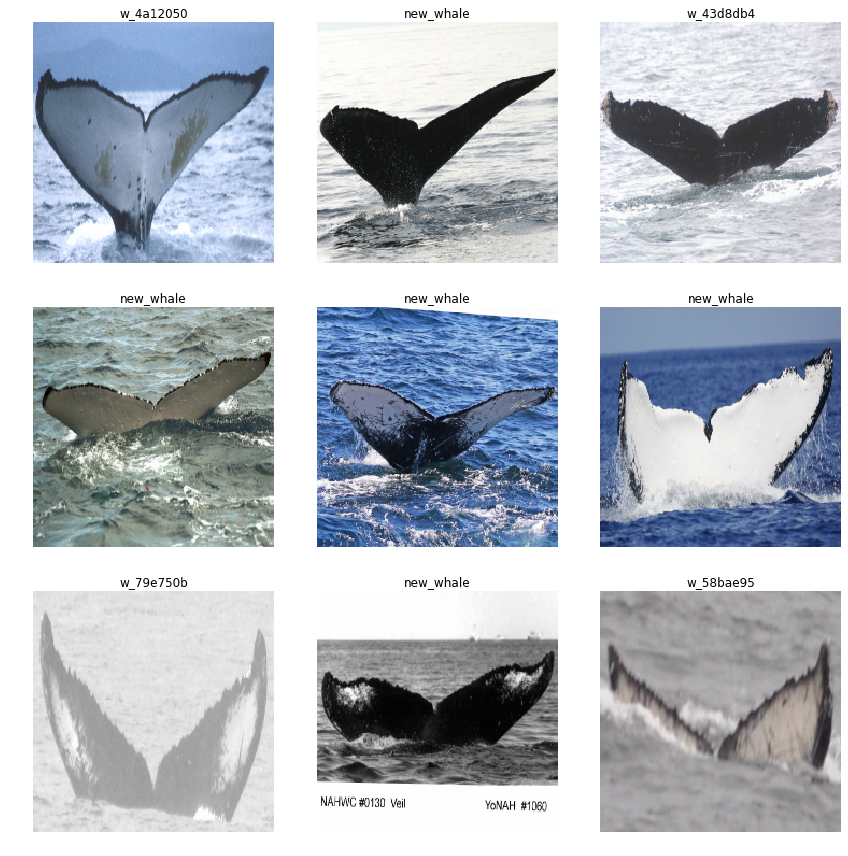

In [23]:
data.show_batch(rows=3)

In [24]:
name = f'res50-{SZ}'

In [30]:
def map5kfast(preds, targs, k=10):
    predicted_idxs = preds.sort(descending=True)[1]
    top_5 = predicted_idxs[:, :5]
    scores = torch.zeros(len(preds), k).float()
    for kk in range(k):
        scores[:,kk] = (top_5[:,kk] == targs).float() / float((kk+1))
    return scores.max(dim=1)[0].mean()

In [31]:
def map5(preds, targs):
    return map5kfast(preds, targs, 5)

In [32]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5])

In [33]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,map5
1,5.692825,4.797055,0.431600,0.454356
2,5.050965,4.575441,0.446023,0.475896


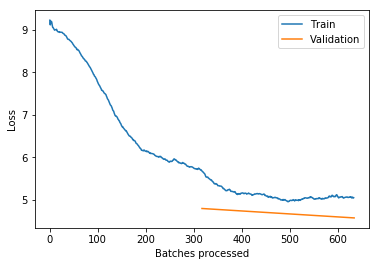

In [34]:
learn.recorder.plot_losses()

In [35]:
learn.save(f'{name}-stage-1')

In [36]:
learn.unfreeze()

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-05


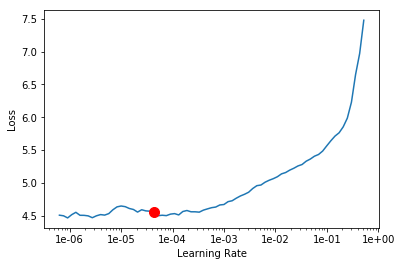

In [39]:
learn.recorder.plot()

In [40]:
max_lr = 1e-4
lrs = [max_lr/100, max_lr/10, max_lr]

In [41]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,4.655704,4.536491,0.447771,0.478904
2,4.449121,4.457548,0.455201,0.488360
3,4.278161,4.392374,0.459790,0.494912
4,4.105113,4.363238,0.463505,0.498783
5,4.022540,4.360967,0.463942,0.499541


In [42]:
learn.save(f'{name}-stage-2')

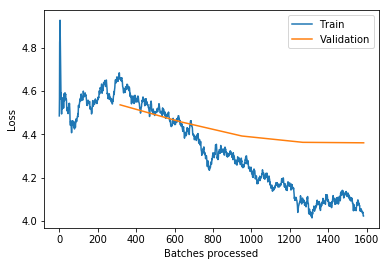

In [43]:
learn.recorder.plot_losses()

In [44]:
preds, _ = learn.get_preds(DatasetType.Test)

In [62]:
def top_5_preds(preds): return np.argsort(preds.numpy())[:, ::-1][:, :5]

def top_5_pred_labels(preds, classes):
    top_5 = top_5_preds(preds)
    labels = []
    for i in range(top_5.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top_5[i]]))
    return labels

def create_submission(preds, data, name, classes=None):
    if not classes: classes = data.classes
    sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub['Id'] = top_5_pred_labels(preds, classes)
    sub.to_csv(f'../submission/{name}.csv.gz', index=False, compression='gzip')

In [63]:
create_submission(preds, learn.data, name)

In [64]:
pd.read_csv(f'../submission/{name}.csv.gz').head()

,Image,Id
0,8a4b5372a.jpg,new_whale w_9b5109b w_89f6097 w_0369a5c w_343f088
1,6894a2017.jpg,w_9c506f6 new_whale w_23a388d w_488865e w_e27bbf6
2,efd1ae9d2.jpg,new_whale w_6e209a8 w_9c506f6 w_eba33fb w_d405854
3,6c48e173b.jpg,new_whale w_f6c5343 w_fd6a3ad w_1834b49 w_3815890
4,7af17248d.jpg,new_whale w_53feb91 w_91cc02c w_fd3e556 w_bfe77d0


In [55]:
kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

/bin/sh: 1: kaggle: not found
